# Brain Tumor Classfication

## Loading Data

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/Brain-Tumor-Classification-DataSet

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
100% 149M/149M [00:07<00:00, 24.7MB/s]
100% 149M/149M [00:07<00:00, 20.7MB/s]


In [ ]:

!unzip /content/Brain-Tumor-Classification-DataSet/brain-tumor-mri-dataset.zip -d /content/Brain-Tumor-Classification-DataSet/

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers, models
from plotly.subplots import make_subplots
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from PIL import Image
import plotly.offline as pyo
from IPython.display import display
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from collections import Counter
from tqdm import tqdm
import random

In [ ]:
train_data = '/content/Brain-Tumor-Classification-DataSet/Training'
test_data = '/content/Brain-Tumor-Classification-DataSet/Testing'

## Data Description & EDA

In [ ]:
# Define categories
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Count the number of images in each category
category_counts = {}

for category in categories:
    category_path = os.path.join(train_data, category)
    if os.path.exists(category_path):  # Check if the path exists
        num_images = len(os.listdir(category_path))
        category_counts[category] = num_images
    else:
        print(f"Path not found: {category_path}")

# Display category counts
print("Number of images in each category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

Number of images in each category:
glioma: 1321
meningioma: 1339
notumor: 1595
pituitary: 1457


In [ ]:
## Visualising Number of Images in Each Category

fig = go.Figure()

# Add bar chart with labels
fig.add_trace(go.Bar(
    x=list(category_counts.keys()),
    y=list(category_counts.values()),
    marker_color=['blue', 'green', 'red', 'purple'],
    text=list(category_counts.values()),  # Add labels
    textposition='auto'  # Display labels on top of the bars
))

# Customize layout
fig.update_layout(
    title="Image Distribution by Category",
    xaxis_title="Category",
    yaxis_title="Number of Images",
    xaxis_tickangle=20,
    font=dict(size=12),
    yaxis=dict(gridcolor='rgba(127,127,127,0.3)')  # Add gridlines
)

# Show the figure
fig.show()

In [ ]:
## Visualising and Checking Distribution of Image Sizes

# Initialize a list to store image sizes
image_sizes = []

# Function to collect image sizes from a directory with a progress bar
def collect_image_sizes(directory):
    # Loop through files with a progress bar
    for root, dirs, files in tqdm(os.walk(directory), desc=f"Processing {directory}"):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                img = Image.open(image_path)
                # Append the (width, height) to the list
                image_sizes.append(img.size)

# Collect image sizes from both the training and testing directories
collect_image_sizes(train_data)
collect_image_sizes(test_data)

# Convert image sizes to a NumPy array for easy manipulation
resolutions = np.array(image_sizes)

# Create a scatter plot figure with Plotly
fig = px.scatter(
    x=resolutions[:, 0],
    y=resolutions[:, 1],
    title="Distribution of Image Resolutions",
    labels={"x": "Width (pixels)", "y": "Height (pixels)"},
    hover_name=[f"{w}x{h}" for w, h in resolutions]
)

# Customize the plot
fig.update_layout(
    showlegend=False,
    hovermode="closest",
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Show the plot
fig.show()

Processing /content/Brain-Tumor-Classification-DataSet/Training: 5it [00:00,  8.13it/s]
Processing /content/Brain-Tumor-Classification-DataSet/Testing: 5it [00:00, 38.68it/s]



### Conclusion:
1. The dataset suffers from class imbalance, the `no_tumor` class being underrepresented.
2. Images in the dataset vary in size, requiring standardization.

### Solutions:
1. Data Augmentation: Apply techniques such as rotation, flipping, and zooming to increase the representation of underrepresented categories.
2. Image Resizing: Normalize all images to a consistent size for uniform processing.

## Data Preprocessing

### Image Resizing

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import os

# Parameters
img_size = 224  # Resize all images to 224x224

def resize_and_save_images(input_dir, output_dir, img_size, categories):
    """
    Resize images and save them to specified directories.

    Parameters:
    - input_dir (str): Directory containing original images.
    - output_dir (str): Directory to save resized images.
    - img_size (int): Desired image size (width and height).
    - categories (list): List of category names.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for category in categories:
        category_dir = os.path.join(output_dir, category)
        os.makedirs(category_dir, exist_ok=True)  # Create category-specific directory if it doesn't exist

        folderPath = f'{input_dir}/{category}'

        for filename in tqdm(os.listdir(folderPath), desc=f"Processing {category}"):
            img_path = f'{folderPath}/{filename}'
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                # Save the resized image to the specified directory
                cv2.imwrite(f'{category_dir}/{filename}', img)

    print("Image resizing and saving completed!")

# Define data directories
train_data_resized = '/content/Brain-Tumor-Classification-DataSet/resized_dataset/Training'
test_data_resized = '/content/Brain-Tumor-Classification-DataSet/resized_dataset/Testing'

# Call the function to resize and save training images
resize_and_save_images(train_data, train_data_resized, img_size, categories)

# Call the function to resize and save testing images
resize_and_save_images(test_data, test_data_resized, img_size, categories)

Processing pituitary: 100%|██████████| 1457/1457 [00:02<00:00, 564.23it/s]


Image resizing and saving completed!


Processing pituitary: 100%|██████████| 300/300 [00:00<00:00, 588.43it/s]

Image resizing and saving completed!


In [ ]:
# Initialize a list to store image sizes
image_sizes = []

# Collect image sizes from both the training and testing directories
collect_image_sizes(train_data_resized)
collect_image_sizes(test_data_resized)

# Convert image sizes to a NumPy array for easy manipulation
resolutions = np.array(image_sizes)

# Create a scatter plot figure with Plotly
fig = px.scatter(
    x=resolutions[:, 0],
    y=resolutions[:, 1],
    title="Distribution of Image Resolutions",
    labels={"x": "Width (pixels)", "y": "Height (pixels)"},
    hover_name=[f"{w}x{h}" for w, h in resolutions]
)

# Customize the plot
fig.update_layout(
    showlegend=False,
    hovermode="closest",
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Show the plot
fig.show()

Processing /content/Brain-Tumor-Classification-DataSet/resized_dataset/Training: 6it [00:00,  9.64it/s]
Processing /content/Brain-Tumor-Classification-DataSet/resized_dataset/Testing: 5it [00:00, 35.19it/s]


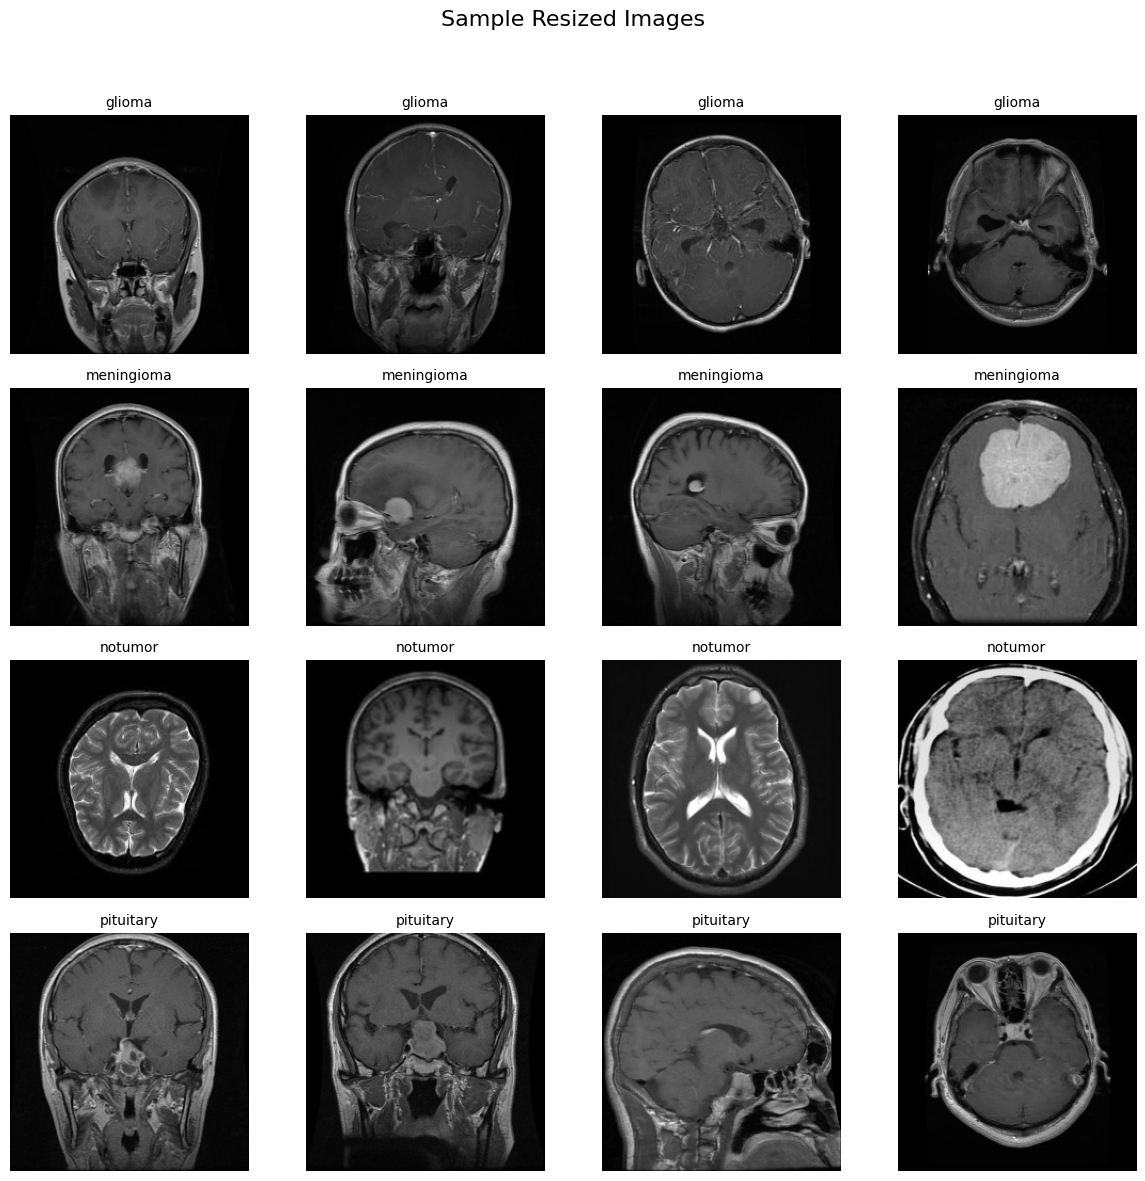

In [ ]:
import matplotlib.pyplot as plt
import random

def display_sample_images(resized_folder, categories, img_size=224, samples_per_category=4):
    """
    Display sample images from the resized dataset.

    Parameters:
    - resized_folder (str): Path to the folder containing resized images.
    - categories (list): List of categories to sample images from.
    - img_size (int): Size of the images (assumes square images).
    - samples_per_category (int): Number of images to display per category.
    """
    fig, axes = plt.subplots(len(categories), samples_per_category, figsize=(samples_per_category * 3, len(categories) * 3))
    fig.suptitle('Sample Resized Images', fontsize=16)

    for i, category in enumerate(categories):
        category_path = f'/content/Brain-Tumor-Classification-DataSet/resized_dataset/Training/{category}'
        images = os.listdir(category_path)

        # Select random samples from the category
        sample_images = random.sample(images, min(samples_per_category, len(images)))

        for j, img_name in enumerate(sample_images):
            img_path = f'/content/Brain-Tumor-Classification-DataSet/resized_dataset/Training/{category}/{img_name}'
            img = cv2.imread(img_path)

            ax = axes[i, j] if len(categories) > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(category, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the title
    plt.show()

# Example usage:
resized_folder = '/content/Brain-Tumor-Classification-DataSet/resized_dataset/Training'
display_sample_images(resized_folder, categories)

### Background Removal

In [ ]:
import cv2
import numpy as np

# Function to remove background from greyscale images
def remove_background(input_directory, output_directory):
    os.makedirs(output_directory, exist_ok=True)  # Create output directory if it doesn't exist

    # Loop through each label in the dataset
    for label in os.listdir(input_directory):
        label_dir = f'{input_directory}/{label}'
        output_label_dir = f'{output_directory}/{label}'
        os.makedirs(output_label_dir, exist_ok=True)  # Create subdirectory for processed images

        for filename in tqdm(os.listdir(label_dir), desc=f"Removing background for {label}"):
            if filename.endswith('.jpg'):
                img_path = f'{label_dir}/{filename}'
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as greyscale

                # Threshold the image to create a binary mask
                _, mask = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)

                # Find contours
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    # Select the largest contour
                    largest_contour = max(contours, key=cv2.contourArea)

                    # Get the bounding rectangle for the largest contour
                    x, y, w, h = cv2.boundingRect(largest_contour)

                    # Crop the image around the bounding rectangle
                    cropped_img = img[y:y+h, x:x+w]

                    # Save the cropped image
                    output_path = f'{output_label_dir}/{filename}'
                    cropped_img = cv2.resize(cropped_img, (img_size, img_size))
                    cv2.imwrite(output_path, cropped_img)

# Directories for the background-removed dataset
train_data_background_removed = '/content/Brain-Tumor-Classification-DataSet/background_removed_dataset/Training'
test_data_background_removed = '/content/Brain-Tumor-Classification-DataSet/background_removed_dataset/Testing'

# Remove background from training and testing images
remove_background(train_data_resized, train_data_background_removed)
remove_background(test_data_resized, test_data_background_removed)

Removing background for meningioma: 100%|██████████| 306/306 [00:00<00:00, 1252.16it/s]


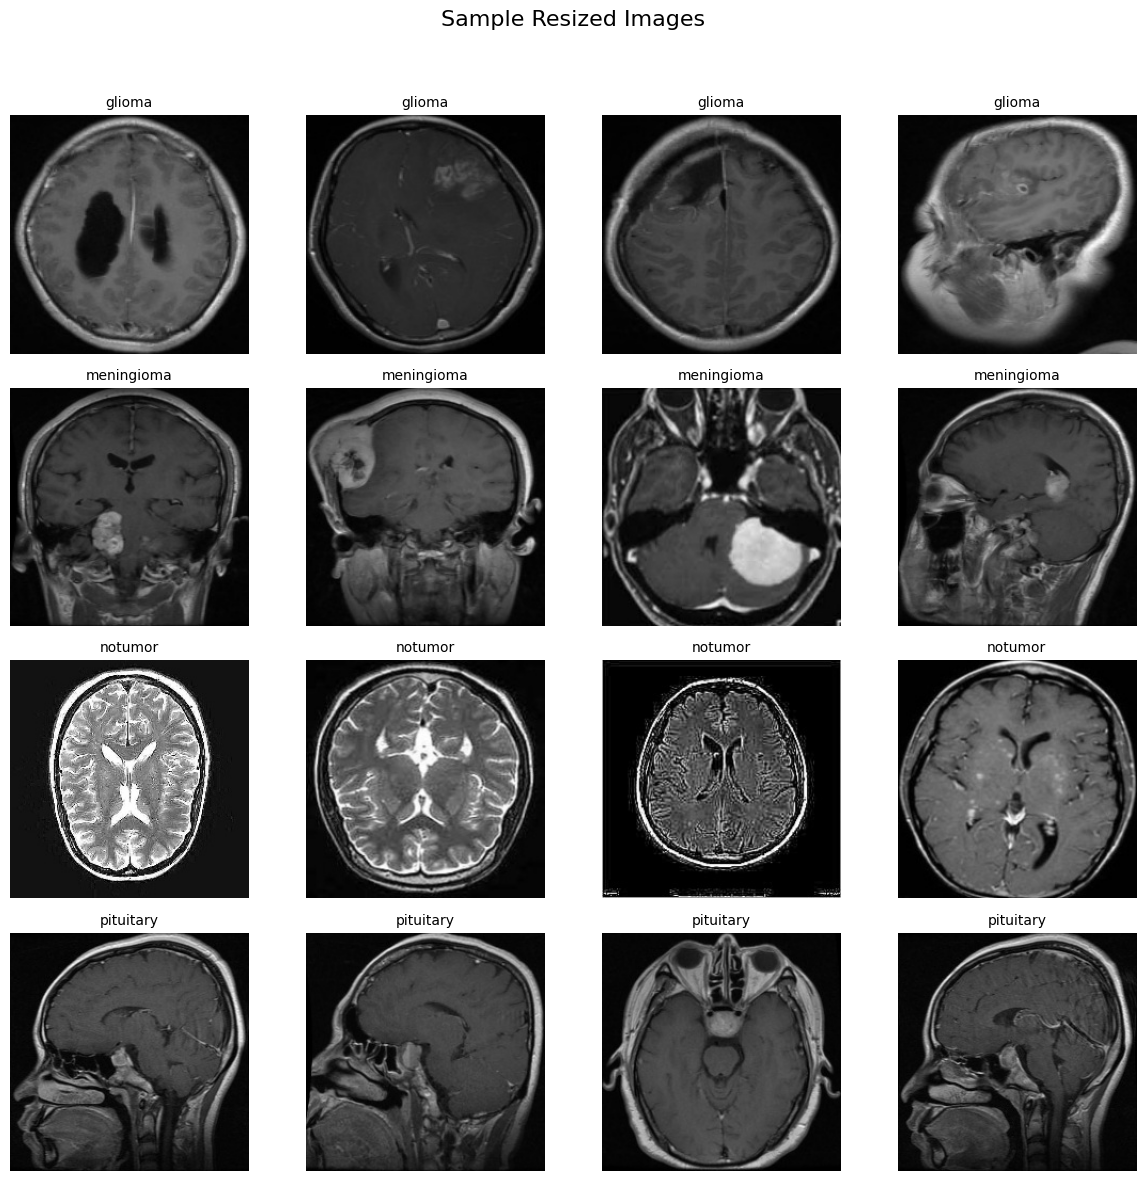

In [ ]:
def display_sample_images(folder, categories, img_size=224, samples_per_category=4):
    """
    Display sample images from the resized dataset.

    Parameters:
    - resized_folder (str): Path to the folder containing resized images.
    - categories (list): List of categories to sample images from.
    - img_size (int): Size of the images (assumes square images).
    - samples_per_category (int): Number of images to display per category.
    """
    fig, axes = plt.subplots(len(categories), samples_per_category, figsize=(samples_per_category * 3, len(categories) * 3))
    fig.suptitle('Sample Resized Images', fontsize=16)

    for i, category in enumerate(categories):
        category_path = f'{folder}/{category}'
        images = os.listdir(category_path)

        # Select random samples from the category
        sample_images = random.sample(images, min(samples_per_category, len(images)))

        for j, img_name in enumerate(sample_images):
            img_path = f'{folder}/{category}/{img_name}'
            img = cv2.imread(img_path)

            ax = axes[i, j] if len(categories) > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(category, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the title
    plt.show()

# Example usage:
display_sample_images(train_data_background_removed, categories)

### Data Augmentation

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

# Define directories and parameters
input_dir = '/content/Brain-Tumor-Classification-DataSet/background_removed_dataset/Training'
output_dir = '/content/Brain-Tumor-Classification-DataSet/augmented-dataset/Training'
target_count = 2000  # Adjust according to the largest class
img_size = 224  # Target size for resizing images

def augment_images(input_dir, output_dir, target_count, img_size):
    """
    Augments images for categories with fewer than target_count images.

    Parameters:
    - input_dir (str): Directory containing background-removed images.
    - output_dir (str): Directory to save augmented images.
    - target_count (int): Desired number of images per category after augmentation.
    - img_size (int): Target size for resizing images.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest'
    )

    for category in os.listdir(input_dir):
        category_input_dir = os.path.join(input_dir, category)
        category_output_dir = os.path.join(output_dir, category)
        os.makedirs(category_output_dir, exist_ok=True)  # Create category-specific output directory

        images = os.listdir(category_input_dir)
        current_count = len(images)
        print(f"Category: {category}, Current Count: {current_count}")

        if current_count < target_count:
            print(f"Augmenting images for {category}...")
            # Progress bar for the current category
            with tqdm(total=target_count - current_count, desc=f"Augmenting {category}", unit="image") as pbar:
                while current_count < target_count:
                    for img_name in images:
                        if current_count >= target_count:
                            break
                        img_path = os.path.join(category_input_dir, img_name)
                        img = load_img(img_path, target_size=(img_size, img_size))
                        img_array = img_to_array(img)
                        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for ImageDataGenerator

                        for batch in datagen.flow(img_array, batch_size=1,
                                                  save_to_dir=category_output_dir,
                                                  save_prefix="aug",
                                                  save_format="jpg"):
                            current_count += 1
                            pbar.update(1)
                            if current_count >= target_count:
                                break

    print("Data augmentation completed!")

# Perform data augmentation
augment_images(input_dir, output_dir, target_count, img_size)


Category: notumor, Current Count: 1595
Augmenting images for notumor...


Augmenting notumor: 100%|██████████| 405/405 [00:04<00:00, 88.24image/s]


Category: pituitary, Current Count: 1457
Augmenting images for pituitary...


Augmenting pituitary: 100%|██████████| 543/543 [00:05<00:00, 90.83image/s]


Category: glioma, Current Count: 1321
Augmenting images for glioma...


Augmenting glioma: 100%|██████████| 679/679 [00:07<00:00, 90.97image/s]


Category: meningioma, Current Count: 1339
Augmenting images for meningioma...


Augmenting meningioma: 100%|██████████| 661/661 [00:07<00:00, 91.74image/s]

Data augmentation completed!


In [ ]:
import os

def check_image_counts(directory):
    """
    Checks the number of images in each category in the specified directory.

    Parameters:
    - directory (str): Path to the directory containing category subdirectories.

    Returns:
    - None: Prints the final count of images for each category.
    """
    print("Image counts after data augmentation:")
    for category in os.listdir(directory):
        category_dir = os.path.join(directory, category)
        if os.path.isdir(category_dir):
            image_count = len(os.listdir(category_dir))
            print(f"Category: {category}, Final Count: {image_count}")

# Directory to check
output_dir = '/content/Brain-Tumor-Classification-DataSet/augmented-dataset/Training'

# Check and display image counts
check_image_counts(output_dir)

Image counts after data augmentation:
Category: glioma, Final Count: 657
Category: notumor, Final Count: 400
Category: meningioma, Final Count: 640
Category: pituitary, Final Count: 526


Displaying samples for category: meningioma


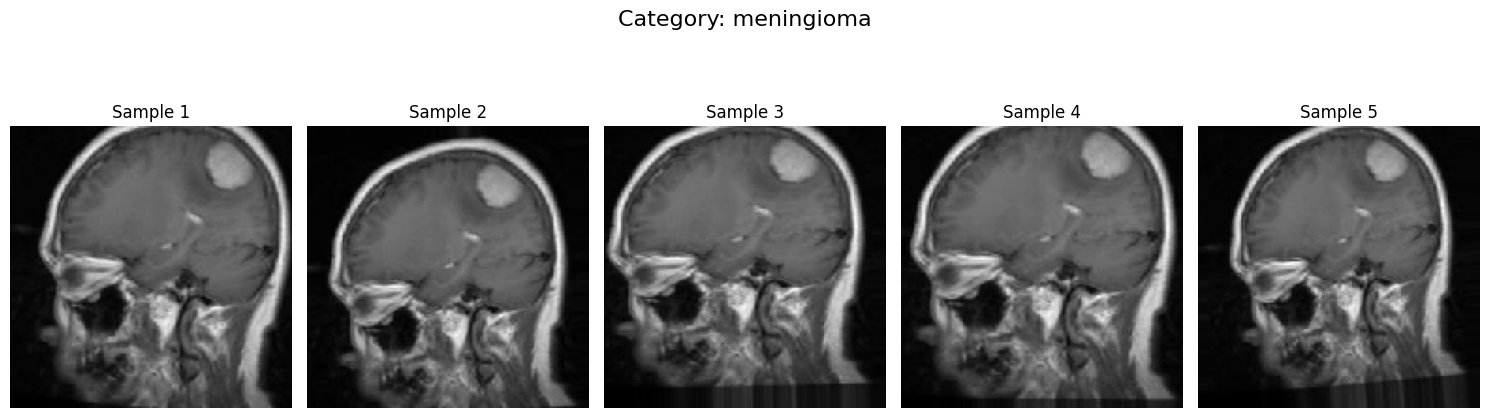

Displaying samples for category: pituitary


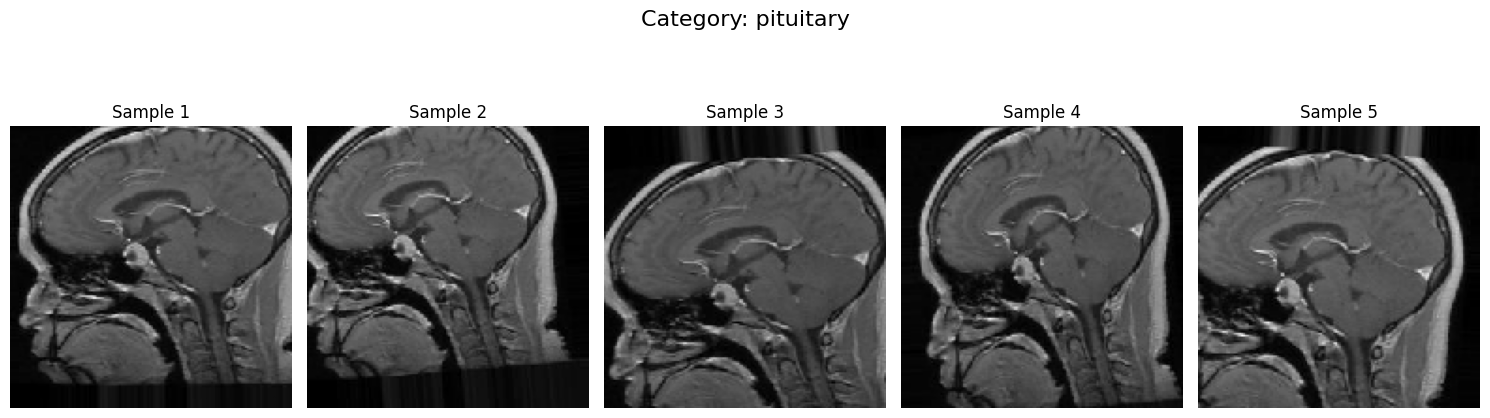

Displaying samples for category: glioma


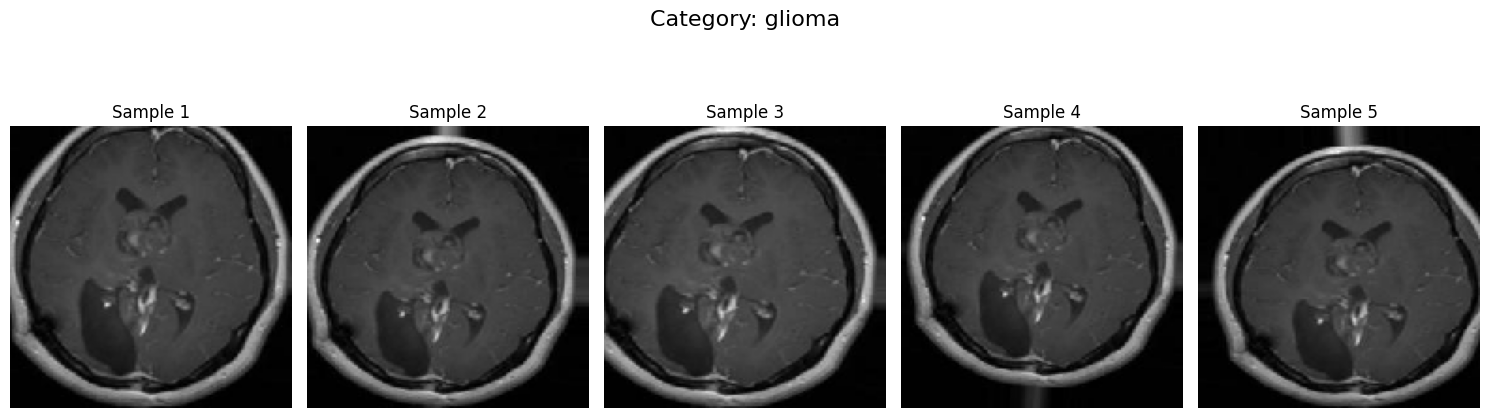

Displaying samples for category: notumor


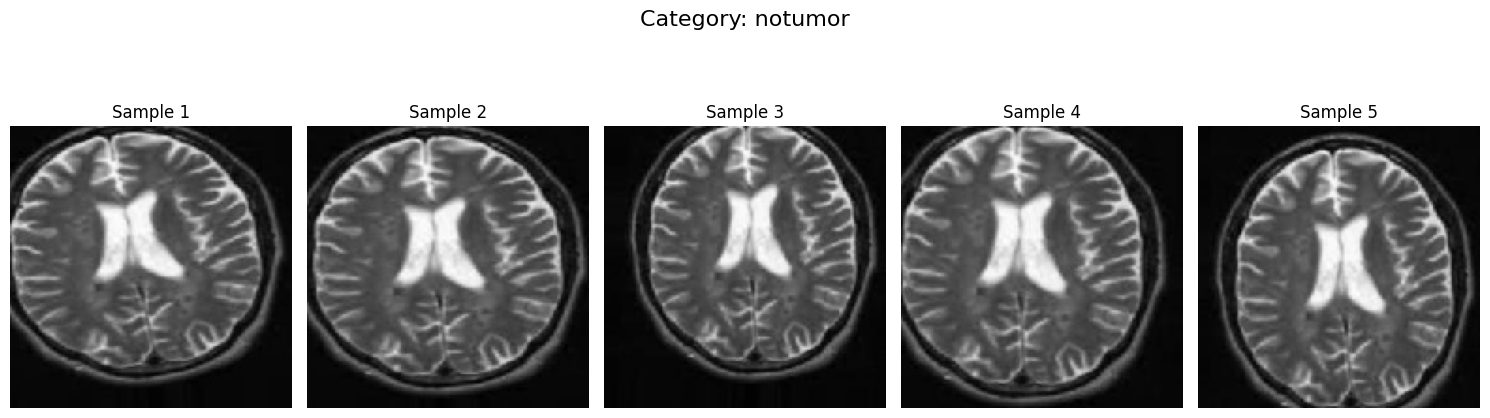

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def display_augmented_samples(augmented_dir, num_samples=5, img_size=(150, 150)):
    """
    Displays random samples of augmented images from each category.

    Parameters:
    - augmented_dir (str): Path to the augmented dataset directory.
    - num_samples (int): Number of images to display per category.
    - img_size (tuple): Target size for loading images.

    Returns:
    - None: Displays the images using matplotlib.
    """
    categories = os.listdir(augmented_dir)

    for category in categories:
        category_path = os.path.join(augmented_dir, category)
        images = os.listdir(category_path)

        if len(images) == 0:
            print(f"No images found in category: {category}")
            continue

        print(f"Displaying samples for category: {category}")
        samples = random.sample(images, min(num_samples, len(images)))

        # Create a figure for the category
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Category: {category}", fontsize=16)

        for i, img_name in enumerate(samples):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # Normalize for better visualization

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img_array)
            plt.axis('off')
            plt.title(f"Sample {i + 1}")

        plt.tight_layout()
        plt.show()

# Define augmented dataset directory and display parameters
augmented_dir = '/content/Brain-Tumor-Classification-DataSet/augmented-dataset/Training'
num_samples = 5  # Number of images to display per category
img_size = (150, 150)  # Image size to display

# Display augmented images
display_augmented_samples(augmented_dir, num_samples, img_size)


In [ ]:
import os
import shutil

def combine_images(original_dir, augmented_dir, combined_dir, min_count):
    """
    Combines original images and augmented images, ensuring each category has at least `min_count` images.

    Parameters:
    - original_dir (str): Path to the directory containing original images.
    - augmented_dir (str): Path to the directory containing augmented images.
    - combined_dir (str): Path to the directory where combined images will be saved.
    - min_count (int): Minimum number of images required in each category.

    Returns:
    - None: Prints the final image counts for each category.
    """
    os.makedirs(combined_dir, exist_ok=True)

    for category in os.listdir(original_dir):
        # Directories for each category
        original_category_dir = os.path.join(original_dir, category)
        augmented_category_dir = os.path.join(augmented_dir, category)
        combined_category_dir = os.path.join(combined_dir, category)
        os.makedirs(combined_category_dir, exist_ok=True)

        # Copy original images
        original_images = os.listdir(original_category_dir)
        for image in original_images:
            src = os.path.join(original_category_dir, image)
            dst = os.path.join(combined_category_dir, image)
            shutil.copy(src, dst)

        # Copy augmented images until the total count reaches `min_count`
        augmented_images = os.listdir(augmented_category_dir)
        total_count = len(original_images)
        for image in augmented_images:
            if total_count >= min_count:
                break
            src = os.path.join(augmented_category_dir, image)
            dst = os.path.join(combined_category_dir, image)
            shutil.copy(src, dst)
            total_count += 1

        # Print final count for the category
        final_count = len(os.listdir(combined_category_dir))
        print(f"Category: {category}, Final Count: {final_count}")

# Define directories and parameters
original_dir = '/content/Brain-Tumor-Classification-DataSet/background_removed_dataset/Training'
augmented_dir = '/content/Brain-Tumor-Classification-DataSet/augmented-dataset/Training'
combined_dir = '/content/Brain-Tumor-Classification-DataSet/combined-dataset/training'
min_count = 2000  # Minimum images required per category

# Combine images and ensure minimum count
combine_images(original_dir, augmented_dir, combined_dir, min_count)


Category: notumor, Final Count: 1993
Category: pituitary, Final Count: 1982
Category: glioma, Final Count: 1972
Category: meningioma, Final Count: 1970


### Data Preparation

In [ ]:
from re import X
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Parameters
img_size = 224  # Resize all images to 224x224
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Function to load images and corresponding labels
def load_images_and_labels(directory, categories, img_size):
    x_data = []
    y_labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        for filename in tqdm(os.listdir(category_path), desc=f"Loading images for {category}"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(category_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, (img_size, img_size))
                    x_data.append(img_resized)
                    y_labels.append(label)

    return np.array(x_data), np.array(y_labels)

# Load training data
x_train, y_train = load_images_and_labels('/content/Brain-Tumor-Classification-DataSet/combined-dataset/training', categories, img_size)

# Load test data
X_test, y_test = load_images_and_labels('/content/Brain-Tumor-Classification-DataSet/background_removed_dataset/Testing', categories, img_size)

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=66)

print(f"Training data count: {len(X_train)}")
print(f"Validation data count: {len(X_val)}")
print(f"Testing data count: {len(X_test)}")


Loading images for pituitary: 100%|██████████| 300/300 [00:00<00:00, 3061.16it/s]


Training data count: 6927
Validation data count: 990
Testing data count: 1311


In [ ]:
np.unique(y_train)

array([0, 1, 2, 3])

In [ ]:
print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_val shape: {(X_val).shape}\n'
      f'y_val shape: {(y_val).shape}')

X_train shape: (6943, 224, 224)
y_train shape: (6943,)
X_test shape: (1311, 224, 224)
y_test shape: (1311,)
X_val shape: (992, 224, 224)
y_val shape: (992,)


### Normalization

In [ ]:
x_train_plot, y_train_plot = load_images_and_labels('/content/Brain-Tumor-Classification-DataSet/Training', categories, img_size)

Loading images for pituitary: 100%|██████████| 1457/1457 [00:01<00:00, 1246.66it/s]


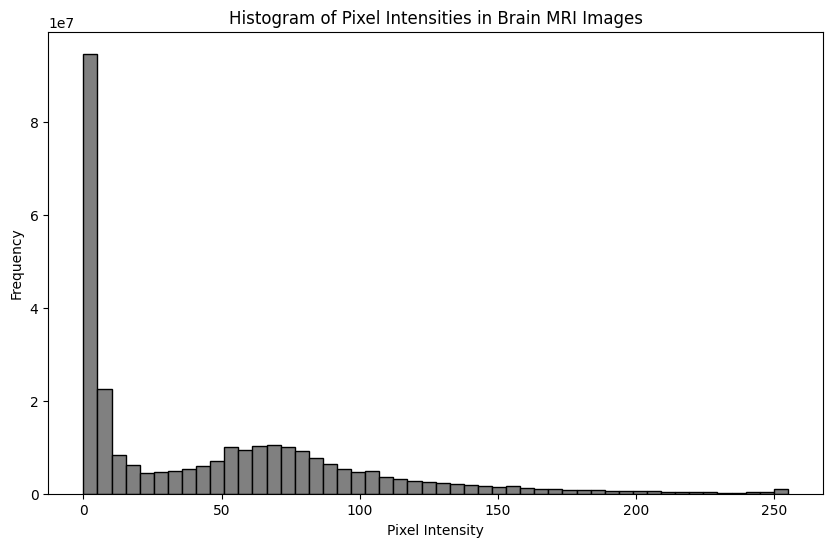

In [ ]:
import numpy as np
import plotly.express as px

# Flatten X_train to get all pixel values into a single array
pixel_values = x_train_plot.flatten()

# Plot the histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='gray', edgecolor='black')
plt.title('Histogram of Pixel Intensities in Brain MRI Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

We can infer from the graph that pixels having an intensity of 0 (black or near-black pixels in greyscale) occur alot more than other pixel intensities

Why are such pixels so prominent in the images?
This kind of distribution is actually common in MRI scans where there may be large dark areas (background or regions outside the brain).

After viewing the pixel intensity distribution, we can deduce that Min-Max Normalization might not be suitable in this case because the pixel intensity distribution is heavily skewed toward the lower end (with many 0 values). This could cause the lower range of pixels to dominate the normalization process, leading to loss of information.

In [ ]:
import numpy as np

# Z-score normalization function
def z_score_normalize(data):
    mean = np.mean(data, axis=(0, 1, 2), keepdims=True)  # Calculate mean across height, width, and channels
    std = np.std(data, axis=(0, 1, 2), keepdims=True)    # Calculate standard deviation across height, width, and channels
    return (data - mean) / std

# Apply Z-score normalization
X_train_norm = z_score_normalize(X_train)
X_val_norm = z_score_normalize(X_val)
X_test_norm = z_score_normalize(X_test)

# Print the shapes and verification
print(f'X_train mean: {np.mean(X_train_norm):.2f}, std: {np.std(X_train_norm):.2f}')
print(f'X_val mean: {np.mean(X_val_norm):.2f}, std: {np.std(X_val_norm):.2f}')
print(f'X_test mean: {np.mean(X_test_norm):.2f}, std: {np.std(X_test_norm):.2f}')

X_train mean: 0.00, std: 1.00
X_val mean: -0.00, std: 1.00
X_test mean: -0.00, std: 1.00


In [ ]:
X_train_norm = np.expand_dims(X_train_norm, axis=-1)  # Shape becomes (6144, 224, 224, 1)
X_val_norm = np.expand_dims(X_val_norm, axis=-1)      # Shape becomes (1536, 224, 224, 1)
X_test_norm = np.expand_dims(X_test_norm, axis=-1)

print("X_train_norm: ", X_train_norm.shape)
print("X_val_norm: ", X_val_norm.shape)
print("X_test_norm: ", X_test_norm.shape)

X_train_norm:  (6927, 224, 224, 1)
X_val_norm:  (990, 224, 224, 1)
X_test_norm:  (1311, 224, 224, 1)


# Model Building

## Advanced Model (CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Parameters
img_size = 224  # Resize all images to 224x224
num_classes = 4  # Number of classes: Glioma, Meningioma, Pituitary, No Tumor

# Model Architecture
model = models.Sequential()

# Input Layer
model.add(layers.Input(shape=(img_size, img_size, 1)))

# Convolutional Layers with updated filters and Dropout
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.3))  # Updated dropout rate

model.add(layers.Conv2D(96, (5, 5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.4))  # Updated dropout rate

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(layers.Dropout(0.4))  # Updated dropout rate

# Fully Connected Layer with updated units and Dropout
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))  # Updated dropout rate

# Output Layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with updated learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 96)        │         153,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 56, 56, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 256)         │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      51,380,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,757,284 (197.44 MB)

 Trainable params: 51,757,284 (197.44 MB)

 Non-trainable params: 0 (0.00 B)

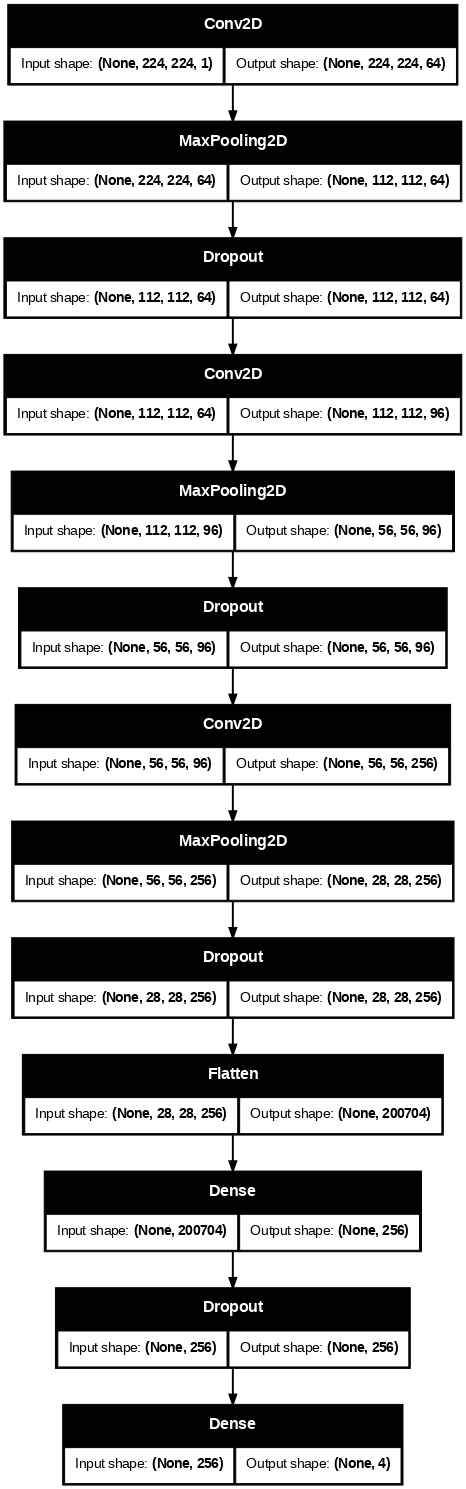

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='/content/model.png', dpi=70,)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# In model.fit(), add the early stopping callback
model.fit(X_train_norm, y_train,
          epochs=20,
          validation_data=(X_val_norm, y_val),
          shuffle= False)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5608 - loss: 1.0830 - val_accuracy: 0.8263 - val_loss: 0.5974
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8102 - loss: 0.5106 - val_accuracy: 0.8727 - val_loss: 0.4188
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8664 - loss: 0.3725 - val_accuracy: 0.8919 - val_loss: 0.3456
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8916 - loss: 0.2985 - val_accuracy: 0.9071 - val_loss: 0.2808
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9161 - loss: 0.2415 - val_accuracy: 0.9172 - val_loss: 0.2474
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9281 - loss: 0.2101 - val_accuracy: 0.9253 - val_loss: 0.2319
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9356 - loss: 0.1725 - val_accuracy: 0.9394 - val_loss: 0.1881
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9544 - loss: 0.1316 - val_acc

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict on the test data
y_pred = model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8754 - loss: 0.4231
Test Loss: 0.2032
Test Accuracy: 0.9428
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Confusion Matrix:
[[247  45   0   8]
 [  5 287   8   6]
 [  0   1 404   0]
 [  0   2   0 298]]


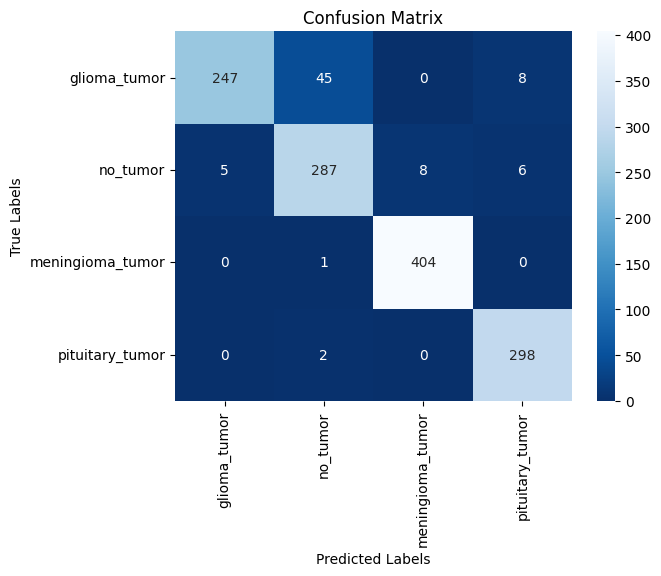

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.82      0.89       300
        no_tumor       0.86      0.94      0.90       306
meningioma_tumor       0.98      1.00      0.99       405
 pituitary_tumor       0.96      0.99      0.97       300

        accuracy                           0.94      1311
       macro avg       0.94      0.94      0.94      1311
    weighted avg       0.95      0.94      0.94      1311



In [ ]:
# Confusion Matrix and Performance Metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification report
report = classification_report(y_test, y_pred_classes, target_names=labels)
print("Classification Report:")
print(report)

# Hyper Parameter Tuning

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the hyperparameter tuning function
def build_model(hp):
    model = models.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(224, 224, 1)))

    # First Convolutional Block
    model.add(layers.Conv2D(hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
                            (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.05)))

    # Second Convolutional Block
    model.add(layers.Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
                            (5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.05)))

    # Third Convolutional Block
    model.add(layers.Conv2D(hp.Int('conv_3_filters', min_value=64, max_value=256, step=64),
                            (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.05)))

    # Fully Connected Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_fc', min_value=0.2, max_value=0.5, step=0.05)))

    model.add(layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate and run Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuning_results',
    project_name='brain_tumor_classification'
)

# Fit the tuner
tuner.search(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=20)

# Retrieve and print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train_norm, y_train, validation_data=(X_val_norm, y_val), epochs=20)

Trial 30 Complete [00h 01m 35s]
val_accuracy: 0.8656565546989441

Best val_accuracy So Far: 0.9646464586257935
Total elapsed time: 00h 21m 48s
Best hyperparameters: {'conv_1_filters': 64, 'dropout_1': 0.30000000000000004, 'conv_2_filters': 96, 'dropout_2': 0.4, 'conv_3_filters': 256, 'dropout_3': 0.4, 'dense_units': 256, 'dropout_fc': 0.4, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.5171 - loss: 1.3492 - val_accuracy: 0.7949 - val_loss: 0.7060
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8120 - loss: 0.5433 - val_accuracy: 0.8677 - val_loss: 0.4969
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8636 - loss: 0.3929 - val_accuracy: 0.8929 - val_loss: 0.3369
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8690 - loss: 0.3498 - val_accuracy: 0.9152 - val_loss: 0.3031
Epoch 5/20
217/217 ━━━━━━━━━━━━━

In [ ]:
!pip install keras-tuner